# **The Problem: Automatic Apparent Age Estimation**
Author: Julio C. S. Jacques Junior

Last modified: Feb 24, 2023.

---



# **Objectives**:

- Play with different machine learning concepts incrementaly.

- Define new strategies to **improve accuracy** performance (overall and per attribute) **while minimizing the different bias scores**.

- Based on your experiments, be able to provide a strong analysis and discussion of the results when delivering your report.

- **IMPORTANT:** as you will see, the problem is basicaly solved in this starting-kit. However, **we expect you to to beyond the starting-kit**. We expect you to play with different hyperparameters, training strategies, different backbones, etc. Avoid making minor changes on the provided code as your final solution. You won't be evaluated based on the accuracy your model provide, but based on your creativity and the way you define the experiments, report and discuss the results (using the report document template - more information will be provided on Virtual Campus).
- **NOTE:** the preliminary discussion provided in this Colab file is based on the results obtained on the **validation set**. You should be able to train different models and evaluate different strategies using the training and validation set. When you are done (that is, when you are satisfied with your results), you can obtain **the final results on the TEST** set using the competition webpage we created for this course. That is, you should not have access to the test labels. We consider this a good excercise where we try to simulate a real situation where people don't have access to the test labels (also usefull to avoid overfitting on the test data). The details about the competition can be found on Virtual Campus.


# Auxiliary and introductory material

Getting Started with TensorFlow in Google Colaboratory
Intro to Google Colab:
https://www.youtube.com/watch?v=inN8seMm7UI


# Pre-requisites and important notes:
- Installing tensorflow and OpenCv.
- Check Colab GPU usage instructions [here](https://research.google.com/colaboratory/faq.html#gpu-availability)

- This code was tested on tensorflow 2.8.2

- Sometimes the code downloads data/models from our server. It may happen that you get a "file not found" error due to some instability of the server. In this case, please keep trying! If the error persist, please contact me.

In [ ]:
!pip install tensorflow==2.8.2
!pip install opencv-python
!pip install h5py

# to enable Colab-GPU version go to 
# "Runtime" -> "Change runtime type" and select GPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


# Downloading and decompressing the [Appa-Real Age Dataset](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)

- Original RGB images (cropped faces) are in the range of [0, 255] and labels are in the range of ~0.9 to ~90 (years old). You will see later that we will re-scale some values to be in the range of [0,1] to make some operations (e.g., training) and eventualy re-scalling the output back (e.g., during evaluation) using a pre-defined normalization factor.
- The data is divided in train, validation and test set. However, **we will omit the Test labels to make the practical sessions more close to a real scenario.** 
- You can train your models with the provided train set and validate it on the validation set, as illustrated below, or you can build your ouwn train/validation set by, for example, merging the provided train/validation data and randomly split them. You are free to define any training strategy. **Your creativity will have a considerable impact on evaluation.**
- Matadata is provided
  - gender: male / female 
  - ethnicity: asian / afroamerican / caucasian
  - facial expression: neutral / slightlyhappy / happy / other


In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data_with-no-test-labels.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data_with-no-test-labels.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data_with-no-test-labels.zip

--2023-03-03 13:27:32--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data_with-no-test-labels.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 803085698 (766M) [application/zip]
Saving to: ‘app_data_with-no-test-labels.zip’

app_data_with-no-te 100%[===================>] 765.88M  6.71MB/s    in 1m 50s  

2023-03-03 13:29:24 (6.98 MB/s) - ‘app_data_with-no-test-labels.zip’ saved [803085698/803085698]

Data decompressed successfully


# Loading the train/validation data, and re-scaling the labels to [0,...,1]
- X_[train,valid,test] = Face images
- Y_[train,valid,test] = Ground truth 
- M_[train,valid,test] = Metadata (gender, ethnicicy, facial expression)

In [ ]:
import numpy as np

# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data (images only) to be used later in our challenge
X_test = np.load('./data/data_test.npy')


# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)


# Visualizing some training samples
Next, we multiply the normalized age labels by 100 to show the original age values on top of each sample.

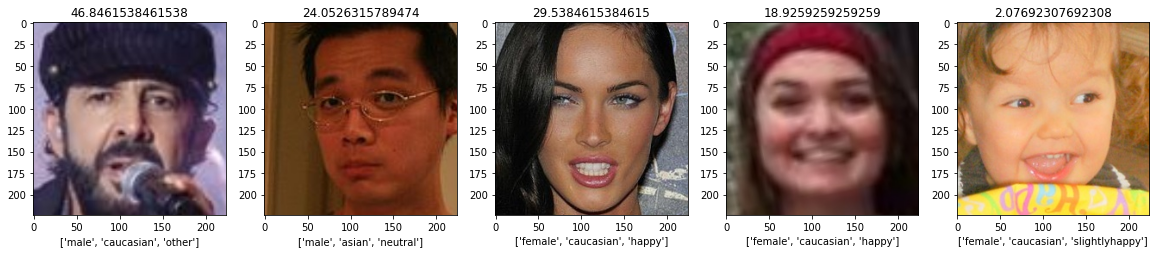

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train))
    ax.imshow(cv2.cvtColor(X_train[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx]*100)
    ax.set(xlabel=[M_train[idx][0],M_train[idx][1],M_train[idx][2]])



# Visualizing the age distribution of Train data

(0.0, 100.0)

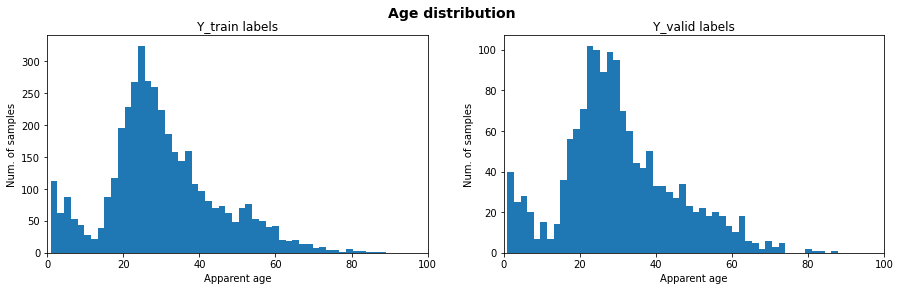

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])

# Visualizing the distributions of metadata (Train data)

(array([1404.,    0.,    0., 1784.,    0.,    0.,  712.,    0.,    0.,
         165.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

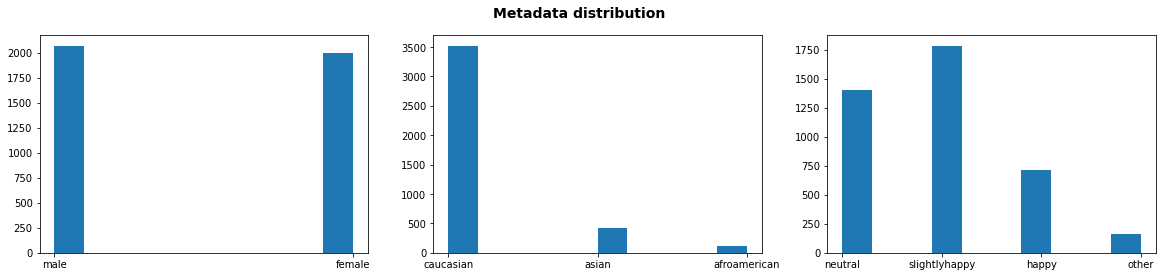

In [ ]:
gender = []
etnhicity = []
emotion = []
for sample in M_train:
  gender.append(sample[0])
  etnhicity.append(sample[1])
  emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)

# Preprocessing the data (face images)
- Later, we will define our model based on ResNet50 (our backbone). Originally,
ResNet50 uses a regularization that changes the range of the input images. Thus,
to be aligned with the ResNet50 input, we preprocess our input images using the respective 'preprocess_input' function. Later, if you decide to use another model as backbone (rather than ResNet), you may skip the following preprocessing stage. Note, **this notebook is used as starting-kit and you are free to use any model architecture, pre-trained model and training strategy.**

In [ ]:
# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = tf.keras.applications.resnet50.preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf.keras.applications.resnet50.preprocess_input(x)  

# Downloading the ResNet50 model pre-trained on Faces
We are using ResNet50 pre-trained on Faces (source [here](https://github.com/ox-vgg/vgg_face2))

In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with ZipFile('model.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm model.zip

--2023-03-03 13:29:46--  http://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893665 (103M) [application/zip]
Saving to: ‘model.zip’

model.zip             2%[                    ]   2.96M   651KB/s    eta 2m 58s 

# Loading the pre-trained model
- You can see the data we have downloaded and the structure of Colab by clicking on 'Files', on the left side (<--) of this interface.



In [ ]:
import h5py

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

# print the model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 base_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['base_input[0][0]']             
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

# Adapting the model to our needs
- In summary, we will ignore the last layer 'classifier_low_dim' and will include a few other layers on top of our backbone. Here, we also define the activation function we are going to use as output of the last FC layer (Sigmoid, in the case). Again, **this notebook is expected to be used as starting-kit. For the deliverabels, avoid simply making minor changes to it. Instead, exploit your creativity as much as you can.**

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems
dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = tf.keras.layers.Dense(128, activation='relu', name='f_128')(fc_512)
fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

# building and pringing the final model
model = tf.keras.models.Model(inputs=model.get_layer('base_input').output,outputs=output)
print(model.summary())

# Freezing the first layers to allow the fine-tuning of the last FC layers (only)
- Next, we set some layer to be trainable or not, and print if layers are set to trainable = True or False.


In [ ]:
counter = 0
for layer in model.layers:
  if counter <= 174: 
    layer.trainable = False
  else:
    layer.trainable = True
  print(counter, layer.name, layer.trainable)
  counter +=1

# Printing the MODEL (summary) we have just defined

In [ ]:
print(model.summary())

# IMPORTANT: Mounting your google drive to save your results
- Colab gives you LIMITED GPU access. Thus, it may kill your process (of training) if you pass a limited amount of training hours. To allow you to save your model while training, you can mount your google drive, as detailed next. This way, if the process is killed, you can (in a new session) load your checkpoints (trained model, from your google drive) and, for example, continue training or make predictions with the model you obtained (even if trained for a few epochs).
- In the following examples, the **the beset model (based on validation loss) is saved in my google drive inside a "/temp/" directory. You will need to addapt this path to your case.** 
- To save time, and to allow you to quickly 'play' and run the notebook, we have pre-trained some models, which are loaded (or not) based on some boolean variables (later, you will need to change/adapt these codes to achive the goals of this course).

In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = False
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.

# Training the Model / or downloading a model already trained
- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST1 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST1 to False to perfom the training.
  - The code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 32, and the model will be trained for 50 epochs (if Colab allows it based to the time budget)
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.

- Note: in case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure. Recommendation: first train your model for a few epochs to avoid the need of resume training. This way, you will get used with the code and the general pipeline. Later, you can play with that.

In [ ]:
import pickle

# load a model and train history (defined and trained
# as below, trained for 38 epochs)
#--------------------------
LOAD_BEST_MODEL_ST1 = True # (training only the last FC layers)
#--------------------------


if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
  
else:
  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model based on val_loss
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])
  
  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Visualizing the train history


In [ ]:
from matplotlib import pyplot as plt

# here, it loads the history of the model we have already trained, or loads the 
# history of the model you defined and trained
if(LOAD_BEST_MODEL_ST1==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')  


# Loading the saved model and making predictions on the Validation set
- Next, we load the trained model and make predictions on the Validation set (for debug purpose, if needed).


In [ ]:
#--------------------------
ENABLE_EVALUATION_ST1 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST1==True):
  saved_model = tf.keras.models.load_model('best_model.h5')
else:
  saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5')

if(ENABLE_EVALUATION_ST1==True):
  # predict on the validation data (normalized outputs)
  predictions_st1_valid = saved_model.predict(X_valid, batch_size=32, verbose=1)

  # re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
  predictions_st1_valid_final = predictions_st1_valid*100

# Re-evaluating the model on the Validation set using the Mean Absolute Error (MAE) as metric (for debug purpose) and printing some predicted results.
- Note, as the train/validation labels were re-scaled to be in the range of [0,1] for training, the predictions will be in the same range [0,1]. Thus, we re-scale them back (to be in the range of "ages") in different sections of this notebook to facilitate the analysis, e.g., when printing output predictions or during evaluations.

In [ ]:
if(ENABLE_EVALUATION_ST1==True):
  # evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st1_valid_final[i][0],Y_valid[i]*100)))

  print('MAE (validation) = %.8f' %(np.mean(error)))

  # printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
  print('-----')
  for i in range(0,10):
    print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st1_valid_final[i], Y_valid[i]*100))

---
---
# Performing a 2nd Stage of training, given the previously trained model, where all layers are set to "trainable"
- Up to here, we have just trained the last FC layers of our model. Now, we will load the model we have trained (referred to it as 1st stage), set all layers to TRAINABLE, and train the whole model. Training will take more time, but we expect to get better results.
- **Note that you are totally free to defien your own training strategy (e.g., using one single stage or multiple stages, freezing as many layers or blocks you want). Please, avoid simply reusing the starting-kit with minor changes, as your creativity will be considered during evaluation.**

In [ ]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
  print(counter, layer.name, layer.trainable)
  counter +=1

# Training the whole model (2nd Stage of training)

- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST2 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST2 to False to perfom the training.
  - As before, the code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 16, and the model will be trained for 12 epochs (if Colab allows it based to the time budget). Note, if you increase the batch size too much, data may not fit the GPU capacity (as the number of parameters to train increased compared to the 1st stage). This is why we reduced it from 32 to 16.
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.
- WARNING: at this stage, training take more time, and colab may close before you finish training due to time constraints. Thus, you will need to define a good strategy! In case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure.
- WARNING: if you save your model and resume training, the train history will be lost. To monitore the training history, you may need to save the train history in another way (e.g., you can copy and paste the logs into a text file before resuming the training).

In [ ]:
# Loding a pretrained model or train
#--------------------------
LOAD_BEST_MODEL_ST2 = True
#--------------------------

if(LOAD_BEST_MODEL_ST2==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
  # decompressing the data
  with ZipFile('best_model_st2.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2.zip

else:
  
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=12, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Visualizing the Training history of both stages (1st stage and 2nd stage)
- Next, we show the train history of the models we have already trained for this course.
- The curves of both stages are concatenated. You can observe a peak close to epoch 42, which indicates the end of the first stage of training and the start of the 2nd stage, and how the 2nd stage improves the performance with respect to validation loss.

In [ ]:
if(LOAD_BEST_MODEL_ST1==True and LOAD_BEST_MODEL_ST2==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
  train_hist_2nd = pickle.load(open("train_history_2nd_stage.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))
  train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

# Re-evaluating the model lerned at the 2nd stage on the Validation set and printing some results
- Next, you can observe a decrease in Mean Absolute Error (MAE) compared to the predictions obtained with the model trained at the 1st stage.

In [ ]:
#--------------------------
ENABLE_EVALUATION_ST2 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST2 == True):
  saved_model_2nd = tf.keras.models.load_model('best_model_2nd_stage.h5')
else:
  saved_model_2nd = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5')


if(ENABLE_EVALUATION_ST2==True):
  # predict on the validation data
  predictions_st2_valid = saved_model_2nd.predict(X_valid, batch_size=32, verbose=1)

  # re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
  predictions_st2_valid_final = predictions_st2_valid*100


In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # evaluating on test data (and re-scalling the labels back to the range of "ages")
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_valid_final[i][0],Y_valid[i]*100)))

  print('MAE (validation) = %.8f' %(np.mean(error)))

  # printing some predictions (in the range of "ages", 
  # after re-scaling the ground truth values back, using the normalization factor)
  print('-----')
  for i in range(0,10):
    print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_valid_final[i], Y_valid[i]*100))

---
---
# Making predictions on the **Test set** and saving the results (predictions.zip) to be uploaded later to our Codalab Competition
- Next, we show how you can save your predictions (on the test set) so that they can be submitted to our Codalab Competition.
- Note, the .csv file MUST be named **'predictions.csv'**, othwerwise you will get an error on Codalab.
- The generated zip file can be submitted on codalab ( <- you can download in from the left part of this web interface).
- You can reuse and adapt this code to generate a submission file for the different results you will obtain during the course.
- Note that in this example we will use the model learned above, resulted from the 2nd stage of training.

> To enter the competition you need to create an account on [Codalab](https://codalab.lisn.upsaclay.fr), register to our competition and submit your predictions to our challenge: **Challenge link and additional instructions are centralized in eCampus**

In [ ]:
# making predictions on the TEST data
predictions_st2_test = saved_model_2nd.predict(X_test, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "ages" as the outputs are in the range of [0,1]
predictions_st2_test_final = predictions_st2_test*100


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_test_final)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions.zip predictions.csv

---
---
############### **Bias mitigation strategies** ###############
---
---
---

# Accuracy is not enough! We also need to evaluate how biased is our model!
- Next, we define different different functions, used to compute a bias score given different attributes.
  - Age bias (4 sub-groups)
  - Gender bias (2 sub-groups) 
  - Ethnicity bias (3 sub-groups)
  - Facial Expression bias (4 sub-groups)
- In a nutshell, given a particular attribute $A$, we compute the Mean Absolute Error $E_n$ for its $N$ sub-groups. We illustrate this process for the case of **Age** next:
- Consider we have 4 sub-groups base on different age ranges (i.e., "0-19", "20-39", "40-59", and "60-100"). We will have one error value per sub-group: $E_1$, $E_2$, $E_3$ and $E_4$.
- Then, we compute the absolute difference among them all. Consider $D$ is a squared matrix where each element $(i,j)$ is the absolute difference between $E_i$ and $E_j$. Then we can retrieve:
  - $D_{2,1} = |E_1-E_2|$
  - $D_{3,1} = |E_1-E_3|$
  - $D_{4,1} = |E_1-E_4|$
  - $D_{3,2} = |E_2-E_3|$
  - $D_{4,2} = |E_2-E_4|$
  - $D_{4,3} = |E_3-E_4|$

- The Final Bias score $B_A$ for attribute $A$ is obtained by the Average of the computed differences. That is:
  - $B_A = \frac{(D_{2,1} + D_{3,1} + D_{4,1} + D_{3,2} + D_{4,2} + D_{4,3})}{6}$
  - In other words: 

   $B_A = \frac{1}{(N^2-N)/2}\sum_{i=1}^{N} \sum_{j=1}^{N} |E_i - E_j|, \forall i,j \in \mathbb{N}^*, \text{if } i < j$

- To minimize your bias score, given a particular attribute, you will need to minimize the absolute difference among the different sub-groups being evaluated. That is, part of your goal will be to make the $N$ sub-groups of each attribute $A$ to have similar errors $E_n$
- The big challenge here is to minimize **ALL** bias scores (i.e., age, gender, ethnicity and face expression).
- Next, we briefly detail the different attributes (and their sub-groups) where the bias scores are evaluated.

---
# Age Bias ($B_a$) 

- Evaluates how accurate the model is with respect to different age ranges.
  - sub-group 1: age < 20
  - sub-group 2: 20 <= age < 40
  - sub-group 3: 40 <= age < 60
  - sub-group 4: 60 <= age



# Gender Bias ($B_g$) 
- Evaluates how accurate the model is with respect to different gender.
  - sub-group 1: male
  - sub-group 2: female


# Ethnicity Bias ($B_e$)
- Evaluates how accurate the model is with respect to different ethnicity categories.
  - sub-group 1: asian
  - sub-group 2: afroamerican
  - sub-group 3: caucasian


# Face expression bias ($B_f$)
- Evaluates how accurate the model is with respect to different face expression categories.
  - sub-group 1: neutral
  - sub-group 2: slightlyhappy
  - sub-group 3: happy
  - sub-group 4: other


---
# Computing the Age, Gender and Ethnicity Biases on the Validation set
- Next, we compute the different bias scores **using the model we obtained after the 2nd stage of training**.
- We re-scale the predictions and labels back to the rage of "ages" using the normalization factor defined before, to make the analysis easier.
- First, we need to **download our "bias library"**, which contains the functions used to evaluate the different bias scores:

In [ ]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
!wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/bias_functions.py

In [ ]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# evaluating the different bias scores
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2)
  age_bias(predictions_st2_valid_final,Y_valid*100)

  # computing the gender bias (model_stage_2)
  gender_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

  # computing the ethnicity bias (model_stage_2)
  ethnicity_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

  # computing the face bias (model_stage_2)
  face_expression_bias(predictions_st2_valid_final,Y_valid*100,M_valid)

---
---
########### **Bias Mitigation (strategy 1)** ##############
---
---
---
# Strategies to improve Accuracy (i.e., to reduce the Error) and mitigate bias: 
- We will comment about two different strategies: 1) data augmentation and 2) custom loss with weighted samples.

# **1) Data augmentation**
- Next, we will augment the train set of people having age >= 60, as this group got the highest MAE compared to the other groups (regarding the age attribute only). 
- Different data augmentation strategies can be used. In this example, we  consider horizontal flip, changing the brighness, gaussian blur and translation.
- **Ideally, you should try to mitigate bias with respect to ALL categories and sub-groups**. 
- **Exploit your creativity as much as you can and avoid simply reusing or making minor changes of this starting-kit.**

In [ ]:
# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')

# Randomly selecting a random image from train set
x = X_train[random.randint(0, len(X_train))]

# flip horizontaly
x_flipped = cv2.flip(x, 1)

# change brightness
x_brigth = cv2.cvtColor(x,cv2.COLOR_RGB2HSV)
x_brigth[:,:,2] = x_brigth[:,:,2]*.5+np.random.uniform()
x_brigth = cv2.cvtColor(x_brigth,cv2.COLOR_HSV2RGB)

# gaussian blur (here you can also play with the function parameters)
x_blur = cv2.GaussianBlur(x,(5,5),1.0)

# translation (randomly translation from -25 to +25 in x and y)
rows, cols ,c= x.shape
M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
x_translate = cv2.warpAffine(x, M, (cols, rows))

# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(x_flipped, cv2.COLOR_BGR2RGB)) # flip horizontaly
ax3.imshow(cv2.cvtColor(x_brigth, cv2.COLOR_BGR2RGB)) # change brightness
ax4.imshow(cv2.cvtColor(x_blur, cv2.COLOR_BGR2RGB)) # gaussian blur
ax5.imshow(cv2.cvtColor(x_translate, cv2.COLOR_BGR2RGB)) # translation

# Applying the data augmentation described above
- Note, for each augmented image, we replicate its original label.

In [ ]:
# aux variables
X_train_augmented = []
Y_train_augmented = []

# loading the train data and labels
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):
  # check if image is in the group 'age >= 60'

  if Y_train[i]*100>=60: # here labels are multiplied by 100 as they were normalized to be between [0,1]
    # flip
    X_train_augmented.append(cv2.flip(X_train[i], 1))
    Y_train_augmented.append(Y_train[i]) 

    # changing brightness
    x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
    Y_train_augmented.append(Y_train[i]) 

    # blur
    X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
    Y_train_augmented.append(Y_train[i])
   
    # translation
    rows, cols ,c= X_train[i].shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows)))
    Y_train_augmented.append(Y_train[i])

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)


# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

---
# **Training the 2nd stage again**, from the model obtained at the 1st stage, but now **using the augmented data**
- As before, we provide a model already trained (using the augmented data), which will be loaded as default if the code below is not changed. 
- You can change the boolean variable LOAD_BEST_MODEL_ST2_AUGMENTATION from True to False in order to train the model again, given your redefined strategy.

In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST2_AUGMENTATION = True
#--------------------------

if(LOAD_BEST_MODEL_ST2_AUGMENTATION==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2_aug.zip
  # decompressing the data
  with ZipFile('best_model_st2_aug.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2_aug.zip

else:
  # loading the saved model (best model learned at stage 1)
  saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5')
  
  # setting all layers to traineble
  saved_model.trainable = True

  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=12, shuffle=True, verbose=1, callbacks=[es,mc])
  

# Train History of the provided pre-trained model

Epoch 1/12
292/292 [==============================] - 63s 194ms/step - loss: 0.2077 - mae: 0.1340 - val_loss: 0.2021 - val_mae: 0.1209
Epoch 2/12
292/292 [==============================] - 58s 197ms/step - loss: 0.1938 - mae: 0.0973 - val_loss: 0.1987 - val_mae: 0.1116
Epoch 3/12
292/292 [==============================] - 58s 197ms/step - loss: 0.1884 - mae: 0.0796 - val_loss: 0.1975 - val_mae: 0.1081
Epoch 4/12
292/292 [==============================] - 58s 198ms/step - loss: 0.1853 - mae: 0.0692 - val_loss: 0.1967 - val_mae: 0.1081
Epoch 5/12
292/292 [==============================] - 58s 197ms/step - loss: 0.1830 - mae: 0.0617 - val_loss: 0.1946 - val_mae: 0.1035
Epoch 6/12
292/292 [==============================] - 58s 199ms/step - loss: 0.1819 - mae: 0.0581 - val_loss: 0.1933 - val_mae: 0.1010
Epoch 7/12
292/292 [==============================] - 58s 198ms/step - loss: 0.1801 - mae: 0.0529 - val_loss: 0.1912 - val_mae: 0.0979
Epoch 8/12
292/292 [==============================] - 59s 202ms/step - loss: 0.1790 - mae: 0.0506 - val_loss: 0.1898 - val_mae: 0.0956
Epoch 9/12
292/292 [==============================] - 59s 200ms/step - loss: 0.1776 - mae: 0.0475 - val_loss: 0.1888 - val_mae: 0.0954
Epoch 10/12
292/292 [==============================] - 57s 196ms/step - loss: 0.1763 - mae: 0.0453 - val_loss: 0.1871 - val_mae: 0.0937
Epoch 11/12
292/292 [==============================] - 58s 199ms/step - loss: 0.1748 - mae: 0.0424 - val_loss: 0.1858 - val_mae: 0.0925
Epoch 12/12
292/292 [==============================] - 58s 199ms/step - loss: 0.1736 - mae: 0.0420 - val_loss: 0.1837 - val_mae: 0.0896

# Evaluating the model (with data augmentation) on the Validation set
- Here, you can observe a decrease in Mean Absolute Error (MAE) compared to the predictions obtained by the previously trained models:
  - Model trained at the 1st stage: MAE = 16.98603930
  - Model trained at the 2nd stage (without data augmentation): MAE = 9.84937248
  - Model trained at the 2nd stage (with data augmentation): MAE = 9.05623911

In [ ]:
# loading the saved model
if(LOAD_BEST_MODEL_ST2_AUGMENTATION==True):
  saved_model_2nd_augm = tf.keras.models.load_model('best_model_2nd_stage_augmentation.h5')
else:
  saved_model_2nd_augm = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')


#--------------------------
ENABLE_EVALUATION_ST2_AUGMENTED = True
#--------------------------

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
  # predict on the test data
  predictions_st2_augmented = saved_model_2nd_augm.predict(X_valid, batch_size=32, verbose=1)
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st2_augmented_final = predictions_st2_augmented*100


In [ ]:
if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
  # evaluating on validation data
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_augmented_final[i][0],Y_valid[i]*100)))

  print('MAE (validation) = %.8f' %(np.mean(error)))

# Computing the Age Bias (augmented data) on the Validation set
- Next, if we compare the age bias obtained by the two models (without/with) data augmentation, we can observed the model with augmented data was able to recude the age bias (from 6.40 to 4.65) on the Validation set. In particular, the MAE for group 4 reduced from 19.45 to 16.28, suggesting that our data augmentation had a positive impact in training.

In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2) - previous model without data augmentation
  age_bias(predictions_st2_valid_final,Y_valid*100)

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):  
  # computing the age bias (model_stage_2) - with data augmentation
  age_bias(predictions_st2_augmented_final,Y_valid*100)

---
---
########### **Bias Mitigation (strategy 2)** ##############
---
---
---
# Strategies to improve Accuracy (i.e., to reduce the Error):
# **2) Custom Loss:** sample weights to deal with inbalanced categories
- Next, we will created a "customized loss", which gives more weight to people having less samples in train data. For this simple example, **we will consider the age range only**. This way, we believe the model will be able to generalize a little bit better to those particular groups. Note that you are expect to build a more strong strategy, aiming to mitigate the bias with respect to all categories.

# Load the Train data again (to remove the augmented data) and generate the weigths 
- First, we will generate a weight for each age group (for g =1 to 4);
- The formula used to calculate the weight for each group $j$ is:

  $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

  Where

    - $w_j$ is the weight for each group $j$,
    - $n_{samples}$ is the number of samples in the train set,
    - $n_{classes}$ is the number of classes (4 in our case, as we divided the ages in 4 groups),
    - $n_{samples,j}$ is the number of samples of class (group) $j$.


In [ ]:
# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100 # normalizing the age values to be between [0,1]

# preprocessing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      g1 +=1
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      g2 +=1
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      g3 +=1
    if(Y_train[i]*100>=60):
      g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

# generating the weights for each group using the equation defined above
w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per group = ', w)

# creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights = []
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      sample_weights.append(w[0])
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      sample_weights.append(w[1])
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      sample_weights.append(w[2])
    if(Y_train[i]*100>=60):
      sample_weights.append(w[3])
sample_weights = np.array(sample_weights)

# I) Using the SAMPLE WEIGHTS to train our model and,
- Next, you will see the code we used to train our model (2nd stage) from the model we obtained at the 1st stage, using the customized loss option with sample weights.
- As default, the code will load the model already trained. 
- You can change the boolean variable 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS' to False to train your model.
- Note, now we include other variables ('RESUME_TRAINING' and 'RESUME_FROM_EPOCH') to allow us resuming training, as well as to inform from what epoch we want to resume the trainind, detailed below.

# II) illustrating how to train + save + stop training + RESUME TRAINING
- **Imagine** you set 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False', 'NUM_EPOCHS = 12' and 'RESUME_TRAINING = False' to train your model the first time.
- Due to Colab limitations, your process stoped the training at the middle of epoch 10, and you saved the best model based on validation loss on epoch 9.
- In the above example, you can resume training from epoch 9 by setting the following parameters:
  - 'RESUME_TRAINING = True'
  - 'RESUME_FROM_EPOCH = 9'

- IMPORTANT: to resume training, you will need to monitor the epoch number where your model stopped before resuming the training, and change the defined variables properly. 
  - Note that the fit function is adapted to receive the sample weights ('sample_weight=sample_weights').
  - Also note that the fit function changes if you are training from epoch 0 (initial_epoch=0) or resume training (initial_epoch=RESUME_FROM_EPOCH). 
  - Finally, note that when you are resuming training, you load your 'best_model_2nd_stage_weighted.h5' instead of the model trained at stage 1 ('best_model.h5').


In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = True
NUM_EPOCHS = 12
#--------------------------
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 9
#--------------------------

if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_weighted.zip
  # decompressing the data
  with ZipFile('best_model_weighted.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_weighted.zip

else:
  # loading the saved model (best model learned at stage 1)
  if(RESUME_TRAINING == False):
    saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5') # load model from stage 1
  else:
    # resume training (stage 2)
    saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')
  
  # setting all layers to traineble
  saved_model.trainable = True

  #=================================================
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
  #=================================================

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5', monitor='val_loss', mode='min', save_best_only=True)

  if(RESUME_TRAINING == False):  
    history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
  else:
    history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es,mc])
  

# Making predictions on the Validation set and Evaluating
- Note that in this case, the model obtained MAE = 11.32504168, which is not the best score compared to the ones obtained before. However, are the evaluated biases better? Let's see!

In [ ]:
if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  saved_model_2nd_weighted = tf.keras.models.load_model('best_model_2nd_stage_weighted.h5')
else:
  saved_model_2nd_weighted = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

#--------------------------
ENABLE_EVALUATION_WEIGHTED = True
#--------------------------

if(ENABLE_EVALUATION_WEIGHTED==True):
  # predict on the test data
  predictions_st2_weighted = saved_model_2nd_weighted.predict(X_valid, batch_size=32, verbose=1)
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st2_weighted_final = predictions_st2_weighted*100

In [ ]:
if(ENABLE_EVALUATION_WEIGHTED==True):
  # evaluating on Validation data
  error = []
  for i in range(0,len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_weighted_final[i][0],Y_valid[i]*100)))

  print('MAE (Validation) = %.8f' %(np.mean(error)))

# printing some predictions
for i in range(0,20):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_weighted_final[i], Y_valid[i]*100))

## Comparing the 2nd stage of training on validation set: 
**case a)** without augmentation/custom loss *vs.* **case b)** without augmentation but with custom loss.




In [ ]:
if(ENABLE_EVALUATION_ST2==True and ENABLE_EVALUATION_WEIGHTED==True):
  age_bias(predictions_st2_valid_final,Y_valid*100)
  age_bias(predictions_st2_weighted_final,Y_valid*100)

  gender_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
  gender_bias(predictions_st2_weighted_final,Y_valid*100,M_valid)

  ethnicity_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
  ethnicity_bias(predictions_st2_weighted_final,Y_valid*100,M_valid)

  face_expression_bias(predictions_st2_valid_final,Y_valid*100,M_valid)
  face_expression_bias(predictions_st2_weighted_final,Y_valid*100,M_valid)

**case a)** without augmentation/custom loss *vs.* **case b)** without augmentation but with custom loss.
- Age bias:
  - case a: 6.408208847045898
  - case b: 2.877239227294922
- Gender bias:
  - case a: 0.49919033
  - case b: 0.60023785
- Ethnicity bias:
  - case a: 1.4386415481567383
  - case b: 1.1498057047526042
- Face Expression bias:
  - case a: 0.4711581865946452
  - case b: 0.7978432973225912

As it can be observed, the model with custom loss and weighted samples obtained smaller bias scores on Age and Ethnicity attributes (on the validation set), even if the weigts were defined based on age attribute only. The strongest effect was on Age attribute, with a reduction from 6.4 to 2.8. The evaluated bias on other attributes increased a bit (i.e., gender and face expression), but still keeping below 1, which can be considered acceptable.  

---
---
# Practical Exercises 
We defined a serie of practical exercises where you will be able to:
- Play with data augmentation;
- Play with custom loss (without data augmentation)
- Be free to propose any strategy (optional excercise)
- Compare the different methods and results incrementaly.

**Additional details and deliverable deadlines can be found on the Virtual Campus.**

- We will use **Codalab** to motivate the students, as they can submit their results on the platform, compete with each other and improve their solutions, but **the ranking shown in the leaderboard will not be considered in the evaluation. This is to justify that more creative solutions will be priefered even if they don't provide the best results.**
- You will be requested to share with the lectors your final **Colab file** (with a clean code and well documented) and a **Report document** where you describe your solution, defined experiments and results, with a clear and progressive analysis). Please, check the class material associated with the practical sessions on the Virtual Campus for more details. 

---
 
 ## Saving your predictions **on the Test set** as a file.zip 
 
Next, you can find a piece of code used to save the predicted results as a zip file that can be uploaded to our compatition. You can adapt it based on your needs.



In [ ]:
# -- saving predictions task 1 (test set) --
# data augmentation /task 1
saved_model_2nd_augm = tf.keras.models.load_model('best_model_2nd_stage_augmentation.h5')
predictions_st2_augmented_test = saved_model_2nd_augm.predict(X_test, batch_size=32, verbose=1)
predictions_st2_augmented_test_f = predictions_st2_augmented_test*100
# saving the predictions as a csv file
import csv
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_augmented_test_f)
csvFile.close()
# compressing the csv file (to be submitted to codalab as prediction)
! zip baseline_results_task_1.zip predictions.csv
# -- saving predictions task 1 (test set) --

In [ ]:
# -- saving predictions task 2 (test set) --
# custom loss /task 2
saved_model_2nd_weighted = tf.keras.models.load_model('best_model_2nd_stage_weighted.h5')
predictions_st2_custom_loss_test = saved_model_2nd_weighted.predict(X_test, batch_size=32, verbose=1)
predictions_st2_custom_loss_test_f = predictions_st2_custom_loss_test*100
# saving the predictions as a csv file
import csv
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_custom_loss_test_f)
csvFile.close()
# compressing the csv file (to be submitted to codalab as prediction)
! zip baseline_results_task_2.zip predictions.csv
# -- saving predictions task 1 (test set) --